In [1]:
import Pkg
Pkg.activate("../../../FinancialPlanner/_wip/TCVAR")

  Activating project at `c:\Users\matsz\programowanie\Optymalizacja_portfela\FinancialPlanner\_wip\TCVAR`


In [2]:
using Revise
using Plots

In [3]:
includet("TCVAR_model.jl")
includet("carter_kohn_algorythm.jl")
includet("utills.jl")

In [ ]:
     
    true_var_coeff = [.6 .3;  .4 .7]
    true_trend_covariance = [.015/50 0 
                             0 .01/100]

    true_cycle_covariance = [.02^2 .0002
                            .0002 .015^2]

     
    true_initial_trend_mean = [.02, .01]
    true_initial_trend_covariance = Matrix(I, 2,2)
    true_initial_cycle_mean = [.0, .0]
    true_initial_cycle_covariance = [.02^2 .0002
                                     .0002 .015^2]
                                   
    
    true_model = tc_var(true_var_coeff, 
                        true_trend_covariance, 
                        true_cycle_covariance, 
                        true_initial_trend_mean, 
                        true_initial_cycle_mean, 
                        true_initial_trend_covariance, 
                        true_initial_cycle_covariance)


    true_states, observations= sample(true_model, 140)

    presample_data, data = observations[1:20,:], observations[21:end,:]

    true_states = true_states[21:end,:]
 
 

120×4 Matrix{Float64}:
 -0.565406  -1.72927  -0.0277026   -0.0558093
 -0.578661  -1.73534  -0.0373797   -0.0544964
 -0.570526  -1.73712  -0.0574781   -0.0639934
 -0.578571  -1.73803  -0.0299102   -0.0473591
 -0.578248  -1.73088  -0.0334451   -0.043308
 -0.568697  -1.72232  -0.0182607   -0.0327798
 -0.583392  -1.69965  -0.0208317   -0.0337357
 -0.586662  -1.68871  -0.0270916   -0.0456429
 -0.579996  -1.70479  -0.0572487   -0.0454486
 -0.593669  -1.72552  -0.0188629   -0.0158379
  ⋮                                
 -0.427681  -1.73301  -0.00235589   0.00451322
 -0.444154  -1.72841  -0.00282845  -0.0102576
 -0.455637  -1.73369  -0.0146448   -0.0136177
 -0.469769  -1.73468   0.00521087  -0.0143048
 -0.468651  -1.72959   0.00206206   0.00154839
 -0.478291  -1.74969   0.024098     0.00456289
 -0.446955  -1.75183   0.0117184    0.00332667
 -0.466963  -1.74724   0.0381765    0.0217006
 -0.448919  -1.74928   0.0742405    0.0581946

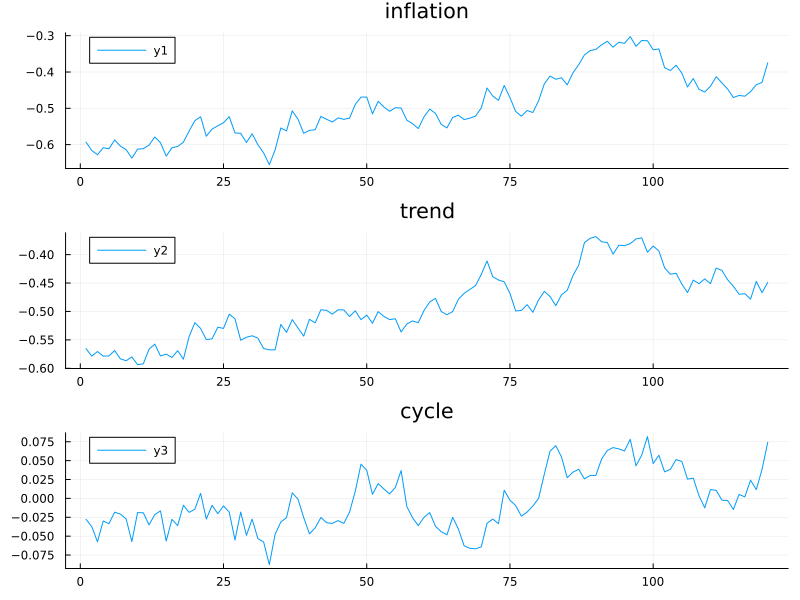

In [21]:
plot_variable_states(data[:, 1], true_states[:, [1,3]], ["inflation" "trend" "cycle"])

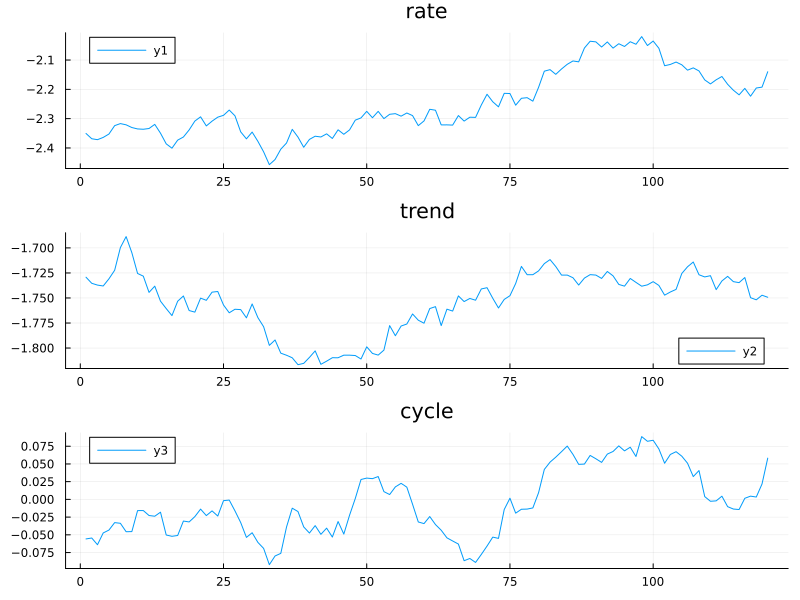

In [22]:
plot_variable_states(data[:, 2], true_states[:, [2,4]], ["rate" "trend" "cycle"])

In [23]:
priors = (
        initial_trend_mean = mean(presample_data, dims=1)[1,:],
        )

(initial_trend_mean = [-0.5756621581924126, -2.3299394714629287],)

In [24]:
model = tc_var(true_var_coeff, 
                        true_trend_covariance, 
                        true_cycle_covariance, 
                        priors.initial_trend_mean, 
                        true_initial_cycle_mean, 
                        true_initial_trend_covariance, 
                        true_initial_cycle_covariance)

StateSpaceModel([1.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0; 0.0 0.0 0.6 0.3; 0.0 0.0 0.4 0.7], [1.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0; 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0], [1.0 0.0 1.0 0.0; 1.0 1.0 0.0 1.0], [0.0003 0.0 0.0 0.0; 0.0 0.0001 0.0 0.0; 0.0 0.0 0.0004 0.0002; 0.0 0.0 0.0002 0.000225], [2.220446049250313e-16 0.0; 0.0 2.220446049250313e-16], [-0.5756621581924126, -2.3299394714629287, 0.0, 0.0], [1.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0; 0.0 0.0 0.0004 0.0002; 0.0 0.0 0.0002 0.000225])

In [25]:
  state_filtered, covariance_filtred, state_predicted, covariance_predicted, ll = kalman_filter(model, data) 
   

   # Run Carter-Kohn sampler
    println("Running Carter-Kohn sampler...")
    state_smoothed_samples = carter_kohn_sampler(model, data, n_samples=10_000)
   
    # Compute posterior statistics
    state_smoothed_mean, state_smoothed_lower, state_smoothed_upper = compute_posterior_statistics(state_smoothed_samples, credible_level=0.95)  
 

Running Carter-Kohn sampler...


([-0.6024912138284135 -1.7504643965584312 0.00938270176800312 0.0024726939058220994; -0.6159667471116802 -1.7504239837593547 -7.38630969257636e-5 -0.002102677590937495; … ; -0.48951916036266446 -1.774200681700875 0.06073243154668944 0.07121332433880984; -0.46240028694094665 -1.7708265141547195 0.08772171249625438 0.09322069487784546], [-0.6437587979063985 -1.7731775294339764 -0.03199141153345127 -0.04162692609310807; -0.6618829447049959 -1.7716341002904432 -0.046799026430996135 -0.0528721058402042; … ; -0.7087438666514045 -1.8486283798165264 -0.15686167535351955 -0.21513597231792841; -0.683096446954616 -1.846430712747374 -0.1308159015740999 -0.19728453719431732], [-0.5611166616339774 -1.7279413785496405 0.05063995919010146 0.045742848635753564; -0.5692451820117768 -1.7293695383452568 0.045819342547165125 0.047732445235918276; … ; -0.2719236997525317 -1.7010873546207013 0.2799498315580432 0.3611808665929965; -0.24386267928203237 -1.6964818065128806 0.3084178756769065 0.38637191889932737

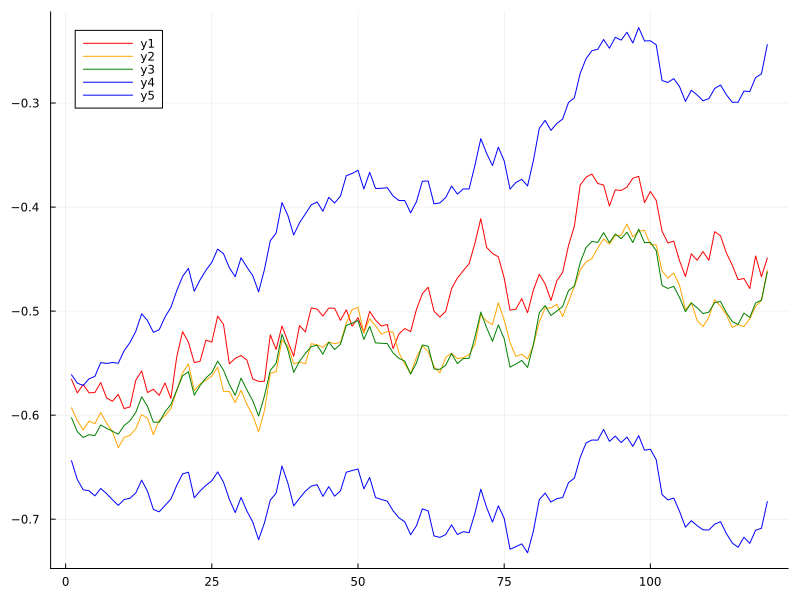

In [27]:
st = 1
plot(true_states[:,st]; color="red", size= (800, 600))
plot!(state_filtered[:,st]; color="orange")
plot!(state_smoothed_mean[:,st], color="green" )
plot!(state_smoothed_lower[:,st], color="blue")
plot!(state_smoothed_upper[:,st], color="blue")

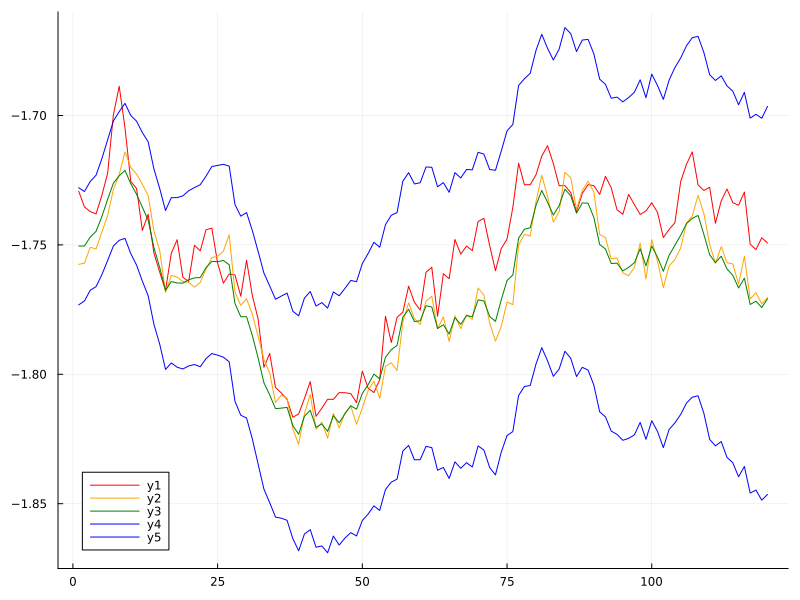

In [28]:
st = 2
plot(true_states[:,st]; color="red", size= (800, 600))
plot!(state_filtered[:,st]; color="orange")
plot!(state_smoothed_mean[:,st], color="green" )
plot!(state_smoothed_lower[:,st], color="blue")
plot!(state_smoothed_upper[:,st], color="blue")

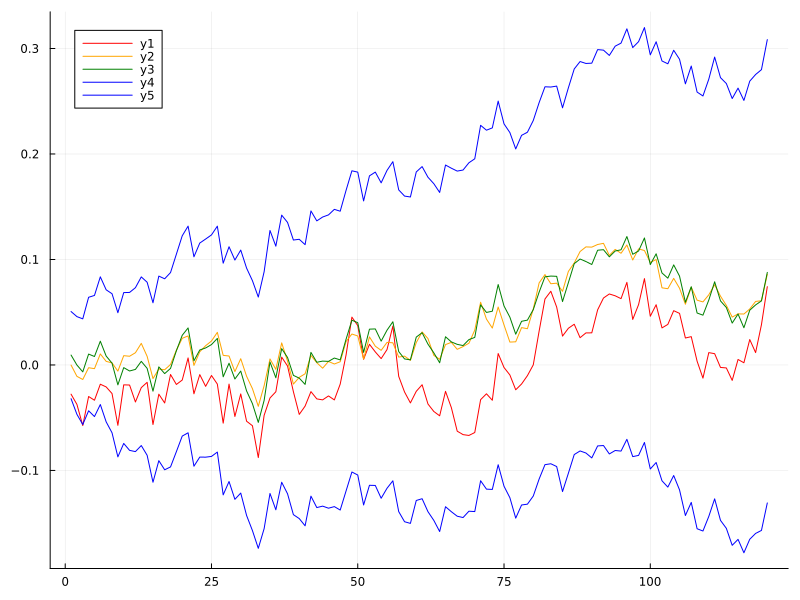

In [29]:
st = 3
plot(true_states[:,st]; color="red", size= (800, 600))
plot!(state_filtered[:,st]; color="orange")
plot!(state_smoothed_mean[:,st], color="green" )
plot!(state_smoothed_lower[:,st], color="blue")
plot!(state_smoothed_upper[:,st], color="blue")

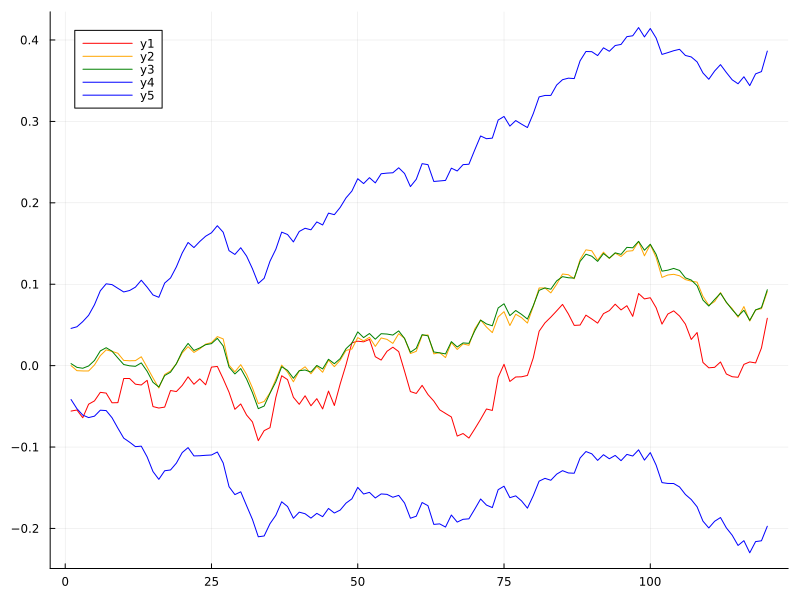

In [30]:
st = 4
plot(true_states[:,st]; color="red", size= (800, 600))
plot!(state_filtered[:,st]; color="orange")
plot!(state_smoothed_mean[:,st], color="green" )
plot!(state_smoothed_lower[:,st], color="blue")
plot!(state_smoothed_upper[:,st], color="blue")